<a href="https://colab.research.google.com/github/jrclavier/aurelius_ds_fin/blob/main/Aurelius_WorkingSheet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 0: To start ...

In [78]:
# Turn on multi-threading on your computer for faster calculation
%env OMP_NUM_THREADS = 4

env: OMP_NUM_THREADS=4


# Step 1 - Install and load the necessary packages and libraries

In [79]:

# Step 1: Load commonly used packages and libraries

import numpy as np # recall that "np" etc. -- are abbreviated names we gave to these packages for notational convenience
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#import warningsimport numpy as np
from scipy import stats
from pandas.api.types import is_numeric_dtype
import seaborn as sns

import sys
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 2 - Load the Intermediate Pre-processed datasets

Output files will be loaded in the next few lines from local or mounted drive for speed. Same could be done from Git or any other source

in detail, sir outputs were produced customers, payments, orders to product, orders to reviews, sellers and geo data

In [80]:

#Start with GEO --> We know there is an issue with a field store values for later

#with open('bad_lines.txt', 'w') as fp:
#    sys.stderr = fp

geo_df = pd.read_csv("/content/drive/MyDrive/Output Tables/output_geo_data.csv",
                          error_bad_lines=False,  engine='python')

#We see a precision issue in the geo data that will be fixed in the next step.. Bad data will be skipped for now

<ipython-input-80-08e1971a85cb>:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  geo_df = pd.read_csv("/content/drive/MyDrive/Output Tables/output_geo_data.csv",
Skipping line 73290: Expected 5 fields in line 73290, saw 7
Skipping line 195493: Expected 5 fields in line 195493, saw 7


In [81]:
#Next Customers and Sellers
path = "/content/drive/MyDrive/Output Tables/"

cust_df = pd.read_csv(path+"output_customers_1.csv", error_bad_lines=False,  engine='python')

#REMEMBER: there is a mistake in the dtypes of the city
seller_df = pd.read_csv(path+"output_seller_city_TOCLEAN_1.csv", error_bad_lines=False,  engine='python')

orders_review_df = pd.read_csv(path+"output_orders_reviews_1.csv", error_bad_lines=False,  engine='python')

orders_product_df = pd.read_csv(path+"output_orders_product_1.csv", error_bad_lines=False,  engine='python')

payments_df = pd.read_csv("/content/drive/MyDrive/Output Tables/output_order_payments.csv",
                          error_bad_lines=False,  engine='python')

<ipython-input-81-6239b535b3d4>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  cust_df = pd.read_csv(path+"output_customers_1.csv", error_bad_lines=False,  engine='python')
<ipython-input-81-6239b535b3d4>:7: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  seller_df = pd.read_csv(path+"output_seller_city_TOCLEAN_1.csv", error_bad_lines=False,  engine='python')
<ipython-input-81-6239b535b3d4>:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  orders_review_df = pd.read_csv(path+"output_orders_reviews_1.csv", error_bad_lines=False,  engine='python')
<ipython-input-81-6239b535b3d4>:11: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the

In [82]:
#INSPECT DATA SETS PRIOR TO CLEAN UP
cust_df.dtypes

customer_id                 object
NOT_customer_unique_id      object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
Cust_Unique_ID              object
dtype: object

In [83]:
geo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720152 entries, 0 to 720151
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   geolocation_zip_code_prefix  720152 non-null  int64  
 1   geolocation_lat              720152 non-null  float64
 2   geolocation_lng              720152 non-null  float64
 3   geolocation_city             720152 non-null  object 
 4   geolocation_state            720152 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 27.5+ MB


In [84]:
seller_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [85]:
orders_product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102425 entries, 0 to 102424
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   product_id                     102425 non-null  object 
 1   Sum_order_item_id              102425 non-null  int64  
 2   order_id                       102425 non-null  object 
 3   seller_id                      102425 non-null  object 
 4   shipping_limit_date            102425 non-null  object 
 5   Sum_price                      102425 non-null  float64
 6   Sum_freight_value              102425 non-null  float64
 7   Right_product_id               102425 non-null  object 
 8   product_category_name          100965 non-null  object 
 9   product_name_lenght            100965 non-null  float64
 10  product_description_lenght     100965 non-null  float64
 11  product_photos_qty             100965 non-null  float64
 12  product_weight_g              

In [86]:
orders_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       99441 non-null  object 
 1   customer_id                    99441 non-null  object 
 2   order_status                   99441 non-null  object 
 3   order_purchase_timestamp       99441 non-null  object 
 4   order_approved_at              99281 non-null  object 
 5   order_delivered_carrier_date   97658 non-null  object 
 6   order_delivered_customer_date  96476 non-null  object 
 7   order_estimated_delivery_date  99441 non-null  object 
 8   review_id                      98673 non-null  object 
 9   review_score                   98673 non-null  float64
 10  review_comment_title           11551 non-null  object 
 11  review_comment_message         40795 non-null  object 
 12  review_creation_date           98672 non-null 

In [87]:
payments_df.dtypes

order_id                    object
Sum_payment_installments     int64
Sum_payment_value            int64
payment_type                object
payment_sequential           int64
dtype: object

In [88]:
geo_df.describe(include='all').round(1)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
count,720152.0,720152.0,720152.0,720152,720152
unique,NaN,NaN,NaN,7921,27
top,NaN,NaN,NaN,sao paulo,SP
freq,NaN,NaN,NaN,79923,274572
mean,38611.2,-21.0,-46.5,NaN,NaN
std,30576.6,5.9,4.4,NaN,NaN
min,1001.0,-36.6,-101.5,NaN,NaN
25%,13043.0,-23.6,-48.9,NaN,NaN
50%,29345.0,-22.9,-46.6,NaN,NaN
75%,66053.0,-19.9,-43.8,NaN,NaN



#Step 3 - "Cleaning" and analyzing the data

Let's start one by one analyzing and inspecting values. Based on our previous inspection in Alteryx, GEO seems to be the most polluted table, followed by seller, product, customers, reviews and lastly payments..

If we follow this order:

### 3.1 GEO Data: Nulls Decimals, Accents driving duplicates

In [89]:
#GEO Analysis, lets fix floats to 3 decimals, and try to see duplicates across columns so we keep unique keys

geo_df.info()

#reconfigure zip to be merged later
#geo_df['geolocation_zip_code_prefix'] = geo_df['geolocation_zip_code_prefix'].astype('datetime64', errors='ignore')

geo_df = geo_df.round(3)

geo_df_s= geo_df.drop_duplicates(keep=False)

geo_df_s.head()

geo_df_s.isnull().mean() * 100

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720152 entries, 0 to 720151
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   geolocation_zip_code_prefix  720152 non-null  int64  
 1   geolocation_lat              720152 non-null  float64
 2   geolocation_lng              720152 non-null  float64
 3   geolocation_city             720152 non-null  object 
 4   geolocation_state            720152 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 27.5+ MB


geolocation_zip_code_prefix    0.0
geolocation_lat                0.0
geolocation_lng                0.0
geolocation_city               0.0
geolocation_state              0.0
dtype: float64

In [90]:
geo_df_zips = geo_df_s.groupby(['geolocation_state','geolocation_city'], as_index=False)\
.agg(value = ('geolocation_zip_code_prefix', 'count'))


In [91]:
#Accents are driving a lot of the duplicates... lets normalize

geo_df_s['geolocation_city'] = geo_df_s['geolocation_city'].str.normalize('NFKD').str.encode('ascii',errors='ignore').str.decode('utf-8')

geo_df_acc= geo_df_s.drop_duplicates(keep=False)

#inspect new dataset
geo_df_zips = geo_df_acc.groupby(['geolocation_state','geolocation_city'], as_index=False)\
.agg(value = ('geolocation_zip_code_prefix', 'count'))

geo_df_zips

geo_df_s.dtypes


<ipython-input-91-f5acf62710b1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_df_s['geolocation_city'] = geo_df_s['geolocation_city'].str.normalize('NFKD').str.encode('ascii',errors='ignore').str.decode('utf-8')


geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object

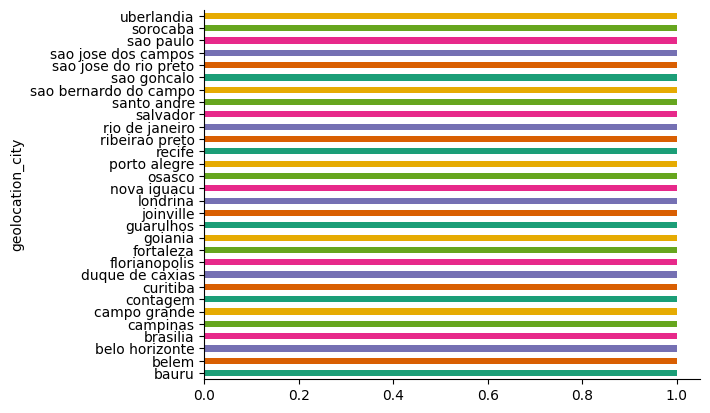

In [92]:

geo_df_zips.nlargest(30, "value").groupby('geolocation_city').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

#### Much Better Now

In [93]:
geo_df_acc.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
2,18046,-23.525,-47.476,sorocaba,SP
4,28026,-21.781,-41.333,campos dos goytacazes,RJ
5,40484,-12.910,-38.474,salvador,BA
6,83823,-25.656,-49.306,fazenda rio grande,PR
10,6550,-23.402,-47.007,pirapora do bom jesus,SP


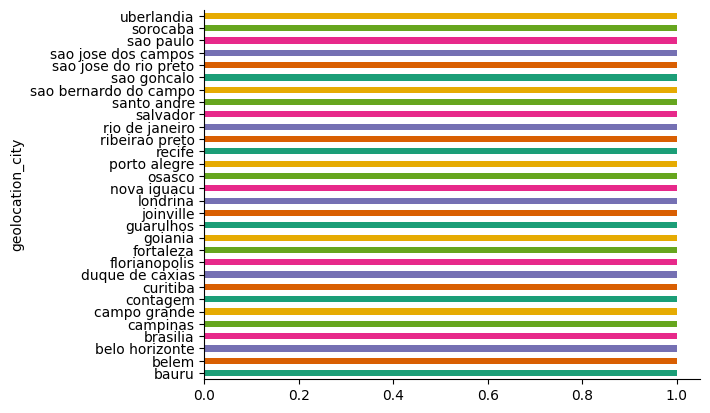

In [94]:
geo_df_zips.nlargest(30, "value").groupby('geolocation_city').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [95]:
# Define types of columns to start driving naming consistency

geo_df_acc.dtypes

geo_df_acc= geo_df_acc.rename(columns={'geolocation_zip_code_prefix': 'zip_code_p','geolocation_city':'city',
                                     'geolocation_state':'state'  })

geo_df_acc['zip_code_p'] = geo_df_acc['zip_code_p'].astype(str)
geo_df_acc.dtypes


zip_code_p          object
geolocation_lat    float64
geolocation_lng    float64
city                object
state               object
dtype: object

### 3.2 Seller Data: Numerical value in city, nulls and Accents test


In [96]:
# Same with Seller data

seller_df.info()
seller_df.head()

# Remove first city is bad but keep to see if the city can be found out later


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,ceb7b4fb9401cd378de7886317ad1b47,22790,04482255,RJ
1,c8143b3069f6746a77421b5ce30a450c,75345,abadia de goias,GO
2,2f4b9d112bfa44a214bc6cef085d17c8,29600,afonso claudio,ES
3,3a52d63a8f9daf5a28f3626d7eb9bd28,71900,aguas claras df,SP
4,717b78b0950b51ed00b1471d858b0edc,18220,alambari,SP


In [97]:
seller_df_zips = seller_df.groupby(['seller_state','seller_city'], as_index=False)\
.agg(value = ('seller_id', 'count'))

seller_df_zips

,seller_state,seller_city,value
0,AC,rio branco,1
1,AM,manaus,1
2,BA,arraial d'ajuda (porto seguro),1
3,BA,bahia,1
4,BA,barro alto,1
...,...,...,...
631,SP,vicente de carvalho,1
632,SP,vila velha,1
633,SP,volta redonda,1
634,SP,votorantim,4


In [98]:
seller_df.isnull().mean() * 100

seller_id                 0.0
seller_zip_code_prefix    0.0
seller_city               0.0
seller_state              0.0
dtype: float64

In [99]:
# Remove accents just in case

seller_df['seller_city'] = seller_df['seller_city'].str.normalize('NFKD').str.encode('ascii',errors='ignore').str.decode('utf-8')
seller_df_acc= seller_df.drop_duplicates(keep=False)

#inspect new dataset
seller_df_acc.describe(include='all').round(1)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
count,3095,3095.0,3095,3095
unique,3095,NaN,609,23
top,ceb7b4fb9401cd378de7886317ad1b47,NaN,sao paulo,SP
freq,1,NaN,695,1849
mean,NaN,32291.1,NaN,NaN
std,NaN,32713.5,NaN,NaN
min,NaN,1001.0,NaN,NaN
25%,NaN,7093.5,NaN,NaN
50%,NaN,14940.0,NaN,NaN
75%,NaN,64552.5,NaN,NaN


In [100]:
# Define types of columns to start driving naming consistency and data types

seller_df_acc.dtypes

seller_df_acc= seller_df_acc.rename(columns={'seller_zip_code_prefix': 'zip_code','seller_city':'city',
                                     'seller_state':'state'  })

seller_df_acc['zip_code_p'] = seller_df_acc['zip_code'].astype(str)
seller_df_acc.drop('zip_code', inplace=True, axis=1, errors='ignore')
seller_df_acc.head()


,seller_id,city,state,zip_code_p
0,ceb7b4fb9401cd378de7886317ad1b47,04482255,RJ,22790
1,c8143b3069f6746a77421b5ce30a450c,abadia de goias,GO,75345
2,2f4b9d112bfa44a214bc6cef085d17c8,afonso claudio,ES,29600
3,3a52d63a8f9daf5a28f3626d7eb9bd28,aguas claras df,SP,71900
4,717b78b0950b51ed00b1471d858b0edc,alambari,SP,18220


### 3.3 Product-Order Data: Post an incomplete translation and a controlled join with the Orders Items, Check for Accents, nulls and Dtypes

All Items from the list where joined to a product ID but not all product IDs were, there are null values in the product specs...

In [101]:
orders_product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102425 entries, 0 to 102424
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   product_id                     102425 non-null  object 
 1   Sum_order_item_id              102425 non-null  int64  
 2   order_id                       102425 non-null  object 
 3   seller_id                      102425 non-null  object 
 4   shipping_limit_date            102425 non-null  object 
 5   Sum_price                      102425 non-null  float64
 6   Sum_freight_value              102425 non-null  float64
 7   Right_product_id               102425 non-null  object 
 8   product_category_name          100965 non-null  object 
 9   product_name_lenght            100965 non-null  float64
 10  product_description_lenght     100965 non-null  float64
 11  product_photos_qty             100965 non-null  float64
 12  product_weight_g              

In [102]:
orders_product_df.describe(include='all').round(2)

,product_id,Sum_order_item_id,order_id,seller_id,shipping_limit_date,Sum_price,Sum_freight_value,Right_product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_error,product_category_name_english
count,102425,102425.00,102425,102425,102425,102425.00,102425.00,102425,100965,100965.00,100965.00,100965.00,102409.00,102409.00,102409.00,102409.00,102425,100943
unique,32951,NaN,98666,3095,555,NaN,NaN,32951,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,71
top,99a4788cb24856965c36a24e339b6058,NaN,ca3625898fbd48669d50701aba51cd5f,6560211a19b47992c3666cc44a7e94c0,2017-11-30,NaN,NaN,99a4788cb24856965c36a24e339b6058,cama_mesa_banho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OK,bed_bath_table
freq,467,NaN,8,1982,1477,NaN,NaN,467,10160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100943,10160
mean,NaN,1.32,NaN,NaN,NaN,132.70,21.99,NaN,NaN,48.87,787.26,2.24,2090.92,30.09,16.41,23.04,NaN,NaN
std,NaN,2.00,NaN,NaN,NaN,205.31,20.46,NaN,NaN,10.00,650.59,1.74,3750.96,16.10,13.31,11.75,NaN,NaN
min,NaN,1.00,NaN,NaN,NaN,0.85,0.00,NaN,NaN,5.00,4.00,1.00,0.00,7.00,2.00,6.00,NaN,NaN
25%,NaN,1.00,NaN,NaN,NaN,44.90,13.52,NaN,NaN,43.00,348.00,1.00,300.00,18.00,8.00,15.00,NaN,NaN
50%,NaN,1.00,NaN,NaN,NaN,81.00,16.85,NaN,NaN,52.00,603.00,2.00,700.00,25.00,13.00,20.00,NaN,NaN
75%,NaN,1.00,NaN,NaN,NaN,147.90,23.26,NaN,NaN,57.00,987.00,3.00,1800.00,38.00,20.00,30.00,NaN,NaN


In [103]:
orders_product_df.isnull().mean() * 100

product_id                       0.000000
Sum_order_item_id                0.000000
order_id                         0.000000
seller_id                        0.000000
shipping_limit_date              0.000000
Sum_price                        0.000000
Sum_freight_value                0.000000
Right_product_id                 0.000000
product_category_name            1.425433
product_name_lenght              1.425433
product_description_lenght       1.425433
product_photos_qty               1.425433
product_weight_g                 0.015621
product_length_cm                0.015621
product_height_cm                0.015621
product_width_cm                 0.015621
product_error                    0.000000
product_category_name_english    1.446912
dtype: float64

In [104]:
# Take a look into product family with some stats

orders_product_df_cat = orders_product_df.groupby(['product_category_name_english'], as_index=False)\
.agg(avg_price = ('Sum_price', 'mean'),avg_freight = ('Sum_freight_value', 'mean'), avg_weight = ('product_weight_g','mean'),
     count_seller = ('seller_id','count'),count_order = ('order_id','count'))


orders_product_df_cat.round(1).sort_values(by=['count_seller'], ascending=False)

,product_category_name_english,avg_price,avg_freight,avg_weight,count_seller,count_order
7,bed_bath_table,102.1,20.1,2157.7,10160,10160
43,health_beauty,139.5,20.2,1069.4,9022,9022
65,sports_leisure,125.7,21.5,1781.4,7858,7858
15,computers_accessories,132.4,21.4,911.8,6887,6887
39,furniture_decor,107.6,25.5,2773.1,6781,6781
...,...,...,...,...,...,...
3,arts_and_craftmanship,75.6,15.4,1369.9,24,24
52,la_cuisine,158.1,25.7,3780.8,13,13
11,cds_dvds_musicals,60.8,18.7,550.0,12,12
29,fashion_childrens_clothes,71.2,11.9,265.0,8,8


In [105]:
orders_product_df.describe(include='all').round(1)

,product_id,Sum_order_item_id,order_id,seller_id,shipping_limit_date,Sum_price,Sum_freight_value,Right_product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_error,product_category_name_english
count,102425,102425.0,102425,102425,102425,102425.0,102425.0,102425,100965,100965.0,100965.0,100965.0,102409.0,102409.0,102409.0,102409.0,102425,100943
unique,32951,NaN,98666,3095,555,NaN,NaN,32951,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,71
top,99a4788cb24856965c36a24e339b6058,NaN,ca3625898fbd48669d50701aba51cd5f,6560211a19b47992c3666cc44a7e94c0,2017-11-30,NaN,NaN,99a4788cb24856965c36a24e339b6058,cama_mesa_banho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OK,bed_bath_table
freq,467,NaN,8,1982,1477,NaN,NaN,467,10160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100943,10160
mean,NaN,1.3,NaN,NaN,NaN,132.7,22.0,NaN,NaN,48.9,787.3,2.2,2090.9,30.1,16.4,23.0,NaN,NaN
std,NaN,2.0,NaN,NaN,NaN,205.3,20.5,NaN,NaN,10.0,650.6,1.7,3751.0,16.1,13.3,11.7,NaN,NaN
min,NaN,1.0,NaN,NaN,NaN,0.8,0.0,NaN,NaN,5.0,4.0,1.0,0.0,7.0,2.0,6.0,NaN,NaN
25%,NaN,1.0,NaN,NaN,NaN,44.9,13.5,NaN,NaN,43.0,348.0,1.0,300.0,18.0,8.0,15.0,NaN,NaN
50%,NaN,1.0,NaN,NaN,NaN,81.0,16.8,NaN,NaN,52.0,603.0,2.0,700.0,25.0,13.0,20.0,NaN,NaN
75%,NaN,1.0,NaN,NaN,NaN,147.9,23.3,NaN,NaN,57.0,987.0,3.0,1800.0,38.0,20.0,30.0,NaN,NaN


### 3.4 Reviews-Order Data: Not all reviews had a corresponding product, not all products a review, This transactional table is key to understand the flow from sellers to buyers

flag review contains whether the order has been reviewed

null values in approval, carrier, delivery and on the reviews

null values in those dates could indicate an operational issue. Interesting to tie to a seller and a given geography

In [106]:
orders_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       99441 non-null  object 
 1   customer_id                    99441 non-null  object 
 2   order_status                   99441 non-null  object 
 3   order_purchase_timestamp       99441 non-null  object 
 4   order_approved_at              99281 non-null  object 
 5   order_delivered_carrier_date   97658 non-null  object 
 6   order_delivered_customer_date  96476 non-null  object 
 7   order_estimated_delivery_date  99441 non-null  object 
 8   review_id                      98673 non-null  object 
 9   review_score                   98673 non-null  float64
 10  review_comment_title           11551 non-null  object 
 11  review_comment_message         40795 non-null  object 
 12  review_creation_date           98672 non-null 

In [107]:
orders_review_df.isnull().mean() * 100

#null values in approval, carrier, delivery and on the reviews
#null values in those dates could indicate an operational issue. Interesting to tie to a seller and a given geography

order_id                          0.000000
customer_id                       0.000000
order_status                      0.000000
order_purchase_timestamp          0.000000
order_approved_at                 0.160899
order_delivered_carrier_date      1.793023
order_delivered_customer_date     2.981668
order_estimated_delivery_date     0.000000
review_id                         0.772317
review_score                      0.772317
review_comment_title             88.384067
review_comment_message           58.975674
review_creation_date              0.773323
review_answer_timestamp           0.773323
review                            0.000000
dtype: float64

In [108]:
#Lets fillna before this to avoid issues

orders_review_df.fillna(0)

orders_review_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review
0,a316eee6dacbc0393c28dff3568a67ee,957f3479d00c3d8aaa4ccb50b22e5ac3,delivered,2018-05-17 14:20:39,2018-05-18 01:35:19,2018-05-18 14:57:00,2018-06-13 23:06:27,2018-06-06 00:00:00,7e211924b558886ca5625fa3f1e41536,1.0,odiei,infelizmente não fui feliz ao realizar essa co...,2018-06-09 00:00:00,2018-06-11 12:55:47,True
1,0653cf037de0812e8ba775b4a0ea9c2f,bf140fe2e3a26db29d95589b4e03b3ac,delivered,2018-01-11 16:30:57,2018-01-11 16:48:40,2018-01-12 21:13:38,2018-01-23 00:41:47,2018-02-07 00:00:00,7149b0b3f5eb5c13e361336974e8febc,1.0,NaN,NaN,2018-01-23 00:00:00,2018-01-24 10:50:31,True
2,12c49270845b0006a7036adda4045c74,9cfce2cdb27217970f887a8c3703116a,delivered,2018-02-21 13:32:45,2018-02-21 14:31:38,2018-02-23 20:23:04,2018-03-16 16:26:23,2018-03-14 00:00:00,06fa2406d29a5719b37315e21bffafeb,2.0,NaN,prazo excedido em muito.,2018-03-16 00:00:00,2018-03-16 11:54:57,True
3,e23ca832ba25d2d20b0ebacdfe401989,320820724a43fe701ae97500b3760a81,shipped,2018-01-24 14:17:10,2018-01-24 15:16:07,2018-01-25 20:15:08,NaN,2018-02-23 00:00:00,1b30acf4a3bc38694ede93b1c8a24221,1.0,NaN,meus caros ainda estou esperando a entrega do ...,2018-02-25 00:00:00,2018-02-26 14:42:10,True
4,47c1a8c65d33d1a87433294bea40a81b,650a53e13d36c61649a28f7547cd5cf3,delivered,2017-05-28 17:05:11,2017-05-28 17:15:10,2017-05-30 17:08:05,2017-06-01 14:11:01,2017-06-19 00:00:00,730f5a89394eae8affa3717ff4e78b11,5.0,NaN,NaN,2017-06-02 00:00:00,2017-06-02 23:44:01,True


In [109]:
# It might be interesting to transform dates and the review into a classifier to be used later


orders_review_df['order_purchase_timestamp'] = orders_review_df['order_purchase_timestamp'].astype('datetime64')
orders_review_df['order_approved_at'] = orders_review_df['order_approved_at'].astype('datetime64')
orders_review_df['order_delivered_carrier_date'] = orders_review_df['order_delivered_carrier_date'].astype('datetime64')
orders_review_df['order_delivered_customer_date'] = orders_review_df['order_delivered_customer_date'].astype('datetime64')
orders_review_df['order_estimated_delivery_date'] = orders_review_df['order_estimated_delivery_date'].astype('datetime64')


orders_review_df['review_creation_date'] = orders_review_df['review_creation_date'].astype('datetime64')
orders_review_df['review_answer_timestamp'] = orders_review_df['review_answer_timestamp'].astype('datetime64')

orders_review_df['review_score'] = orders_review_df['review_score'].astype(str)

orders_review_df.dtypes

orders_review_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review
0,a316eee6dacbc0393c28dff3568a67ee,957f3479d00c3d8aaa4ccb50b22e5ac3,delivered,2018-05-17 14:20:39,2018-05-18 01:35:19,2018-05-18 14:57:00,2018-06-13 23:06:27,2018-06-06,7e211924b558886ca5625fa3f1e41536,1.0,odiei,infelizmente não fui feliz ao realizar essa co...,2018-06-09,2018-06-11 12:55:47,True
1,0653cf037de0812e8ba775b4a0ea9c2f,bf140fe2e3a26db29d95589b4e03b3ac,delivered,2018-01-11 16:30:57,2018-01-11 16:48:40,2018-01-12 21:13:38,2018-01-23 00:41:47,2018-02-07,7149b0b3f5eb5c13e361336974e8febc,1.0,NaN,NaN,2018-01-23,2018-01-24 10:50:31,True
2,12c49270845b0006a7036adda4045c74,9cfce2cdb27217970f887a8c3703116a,delivered,2018-02-21 13:32:45,2018-02-21 14:31:38,2018-02-23 20:23:04,2018-03-16 16:26:23,2018-03-14,06fa2406d29a5719b37315e21bffafeb,2.0,NaN,prazo excedido em muito.,2018-03-16,2018-03-16 11:54:57,True
3,e23ca832ba25d2d20b0ebacdfe401989,320820724a43fe701ae97500b3760a81,shipped,2018-01-24 14:17:10,2018-01-24 15:16:07,2018-01-25 20:15:08,NaT,2018-02-23,1b30acf4a3bc38694ede93b1c8a24221,1.0,NaN,meus caros ainda estou esperando a entrega do ...,2018-02-25,2018-02-26 14:42:10,True
4,47c1a8c65d33d1a87433294bea40a81b,650a53e13d36c61649a28f7547cd5cf3,delivered,2017-05-28 17:05:11,2017-05-28 17:15:10,2017-05-30 17:08:05,2017-06-01 14:11:01,2017-06-19,730f5a89394eae8affa3717ff4e78b11,5.0,NaN,NaN,2017-06-02,2017-06-02 23:44:01,True


In [110]:
orders_review_df.describe(include="all")

orders_review_df.dtypes

<ipython-input-110-5a7b87a42dce>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  orders_review_df.describe(include="all")
<ipython-input-110-5a7b87a42dce>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  orders_review_df.describe(include="all")
<ipython-input-110-5a7b87a42dce>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  orders_review_df.describe(include="all")
<ipython-input-110-5a7

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
review_id                                object
review_score                             object
review_comment_title                     object
review_comment_message                   object
review_creation_date             datetime64[ns]
review_answer_timestamp          datetime64[ns]
review                                     bool
dtype: object

### 3.5 Customer Data: Accents function and Dtypes + check if Not Cust Unique can be used elsewhere

In [111]:
# Same with Seller data

cust_df.info()
cust_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               96096 non-null  object
 1   NOT_customer_unique_id    96096 non-null  object
 2   customer_zip_code_prefix  96096 non-null  int64 
 3   customer_city             96096 non-null  object
 4   customer_state            96096 non-null  object
 5   Cust_Unique_ID            96096 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.4+ MB


,customer_id,NOT_customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,Cust_Unique_ID
0,3a6e7307506713d97cd29c960e5f5a61,763f8a08704b708c43b73507d13ab0ce,5143,sao paulo,SP,Unique
1,fac3296ec4f116faccfa6a6d7e18b42f,4ed128a71a16c4cebc15ed8537d37ed4,15150,monte aprazivel,SP,Unique
2,b49b8fc199c7b5e7f87655ef2d542874,0874cecfab8aecc80ae065af07035e5b,20511,rio de janeiro,RJ,Unique
3,fd72e5a673c5b0cb41b16a6415e622ce,e91806f87029b7c1a2c758317d93b8ba,22723,rio de janeiro,RJ,Unique
4,1373bf3289262687cf4e388a8318d8d5,5d9a935069dbcca38415cb23b8cc4ef4,4195,sao paulo,SP,Unique


In [112]:
cust_df['customer_city'] = cust_df['customer_city'].str.normalize('NFKD').str.encode('ascii',errors='ignore').str.decode('utf-8')
cust_df_acc= cust_df.drop_duplicates(keep=False)

#inspect new dataset
cust_df_acc.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 96096 entries, 0 to 96095
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               96096 non-null  object
 1   NOT_customer_unique_id    96096 non-null  object
 2   customer_zip_code_prefix  96096 non-null  int64 
 3   customer_city             96096 non-null  object
 4   customer_state            96096 non-null  object
 5   Cust_Unique_ID            96096 non-null  object
dtypes: int64(1), object(5)
memory usage: 5.1+ MB


In [113]:
cust_df_acc.isnull().mean() * 100

customer_id                 0.0
NOT_customer_unique_id      0.0
customer_zip_code_prefix    0.0
customer_city               0.0
customer_state              0.0
Cust_Unique_ID              0.0
dtype: float64

In [114]:
cust_df_acc.describe(include='all')

,customer_id,NOT_customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,Cust_Unique_ID
count,96096,96096,96096.000000,96096,96096,96096
unique,96096,96096,NaN,4118,27,1
top,3a6e7307506713d97cd29c960e5f5a61,763f8a08704b708c43b73507d13ab0ce,NaN,sao paulo,SP,Unique
freq,1,1,NaN,14972,40294,96096
mean,NaN,NaN,35186.875302,NaN,NaN,NaN
std,NaN,NaN,29802.691334,NaN,NaN,NaN
min,NaN,NaN,1003.000000,NaN,NaN,NaN
25%,NaN,NaN,11390.000000,NaN,NaN,NaN
50%,NaN,NaN,24440.000000,NaN,NaN,NaN
75%,NaN,NaN,59052.000000,NaN,NaN,NaN


In [115]:
cust_df_acc.dtypes

cust_df_acc=cust_df_acc.rename(columns={'customer_zip_code_prefix': 'zip_code','customer_city':'city',
                                     'customer_state':'state' })

cust_df_acc.drop('NOT_customer_unique_id', inplace=True, axis=1, errors='ignore')
cust_df_acc.drop('Cust_Unique_ID', inplace=True, axis=1, errors='ignore')

cust_df_acc['zip_code_p'] = cust_df_acc['zip_code'].astype(str)
cust_df_acc.drop('zip_code', inplace=True, axis=1, errors='ignore')


cust_df_acc.dtypes

customer_id    object
city           object
state          object
zip_code_p     object
dtype: object

### 3.6 Payments Data

This one can be mapped to the flow and the overall price to track discounts (vouchers)

In [116]:
payments_df.describe().round(1)

,Sum_payment_installments,Sum_payment_value,payment_sequential
count,103886.0,103886.0,103886.0
mean,2.9,153.6,1.1
std,2.7,217.5,0.7
min,0.0,0.0,1.0
25%,1.0,56.0,1.0
50%,1.0,100.0,1.0
75%,4.0,171.0,1.0
max,24.0,13664.0,29.0


In [117]:
payments_df.dtypes

order_id                    object
Sum_payment_installments     int64
Sum_payment_value            int64
payment_type                object
payment_sequential           int64
dtype: object

#Step 4 - Join Geo + Cust & Sellers Table

Idea here is to build a map with all clients and customers in Brazil to see how they are spread across geo. It will look nice in tableau or power BI and it will allow to calculate distance, distribution and other interesting ops kpis



In [118]:
#Join Tables and understand disconn


geo_cust = pd.merge(geo_df_acc,cust_df_acc,on=['zip_code_p','city','state'],how='outer',indicator=True)
print(geo_cust['_merge'].value_counts())
print(geo_cust['_merge'].count())
# Export the join into a CSV file in case you want to play around
geo_cust.to_csv("geo_cust.csv",sep = ';')
#files.download('geo_cust.csv')

print (100*pd.DataFrame({'Percentage at each sub set of a join, Left is Geo, Rigth is Cust and Both is match': geo_cust.groupby(['_merge']).size() / len(geo_cust)}))



both          4664305
left_only       21956
right_only        326
Name: _merge, dtype: int64
4686587
            Percentage at each sub set of a join, Left is Geo, Rigth is Cust and Both is match
_merge                                                                                        
left_only                                            0.468486                                 
right_only                                           0.006956                                 
both                                                99.524558                                 


In [119]:
geo_cust.drop('_merge', inplace=True, axis=1, errors='ignore')

geo_cust.drop_duplicates(keep=False, inplace=True)

geo_cust.shape

(4686587, 6)

In [120]:
geo_sell = pd.merge(geo_df_acc,seller_df_acc,on=['zip_code_p','city','state'],how='outer',indicator=True)
print(geo_sell['_merge'].value_counts())
print(geo_sell['_merge'].count())

geo_sell.to_csv("geo_sell.csv",sep = ';')
#files.download('geo_cust.csv')

print('')
print (100*pd.DataFrame({'Percentage at each sub set of a join, Left is Geo, Rigth is Seller and Both is match': geo_sell.groupby(['_merge']).size() / len(geo_sell)}))
print('makes sense to have only a few Zips for distribution centers')

left_only     309288
both          149641
right_only       133
Name: _merge, dtype: int64
459062

            Percentage at each sub set of a join, Left is Geo, Rigth is Seller and Both is match
_merge                                                                                          
left_only                                           67.373906                                   
right_only                                           0.028972                                   
both                                                32.597122                                   
makes sense to have only a few Zips for distribution centers


In [121]:

geo_cust_sell = pd.merge(geo_cust,seller_df_acc,on=['zip_code_p','city','state'],how='outer',indicator=True)
print(geo_cust_sell['_merge'].value_counts())
print(geo_cust_sell['_merge'].count())


print('')
print (100*pd.DataFrame({'Percentage at each sub set of a join, Left is Geo_Cust, Rigth is Seller and Both is match': geo_cust_sell.groupby(['_merge']).size() / len(geo_cust_sell)}))
print('makes sense to have only a few Zips for distribution centers')

both          3500845
left_only     2859340
right_only        131
Name: _merge, dtype: int64
6360316

            Percentage at each sub set of a join, Left is Geo_Cust, Rigth is Seller and Both is match
_merge                                                                                               
left_only                                           44.955942                                        
right_only                                           0.002060                                        
both                                                55.041998                                        
makes sense to have only a few Zips for distribution centers


In [122]:
geo_cust_sell['seller_id']=geo_cust_sell['seller_id'].fillna('None')

geo_cust_sell.head()

,zip_code_p,geolocation_lat,geolocation_lng,city,state,customer_id,seller_id,_merge
0,18046,-23.525,-47.476,sorocaba,SP,87fcd3ae8cefbde105ade8be91dbbe7b,None,left_only
1,18046,-23.525,-47.476,sorocaba,SP,22cb1d75b185fb6f9b9c74e1033d4c87,None,left_only
2,18046,-23.525,-47.476,sorocaba,SP,98ff94917d9bc917b63d1d49f35975fd,None,left_only
3,18046,-23.525,-47.476,sorocaba,SP,0ec7fc82a014f62c13bf934aa074185d,None,left_only
4,18046,-23.525,-47.476,sorocaba,SP,a19cfe9d36bd6c3ad4e4cee2d165d366,None,left_only


## GEO Data Visualization

1. Market
2. Customers
3. Sellers

<ipython-input-123-eb8487b6abaf>:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


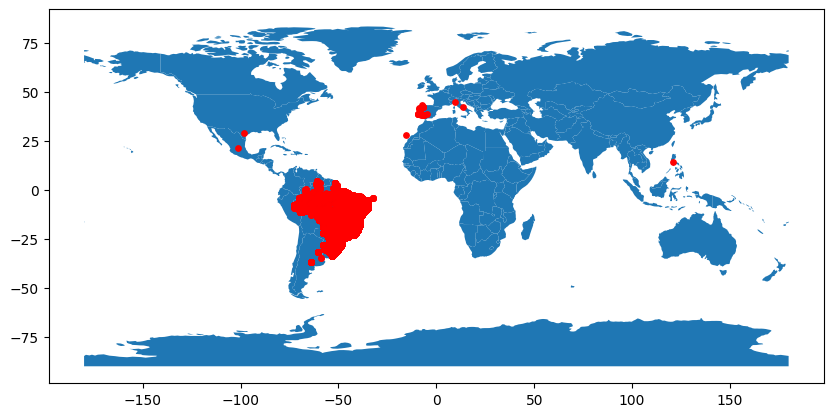

In [123]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame


geometry = [Point(xy) for xy in zip(geo_cust_sell['geolocation_lng'],
                                    geo_cust_sell['geolocation_lat'])]
gdf2 = GeoDataFrame(geo_cust_sell, geometry=geometry)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf2.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

<ipython-input-124-4abf8c91acd2>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


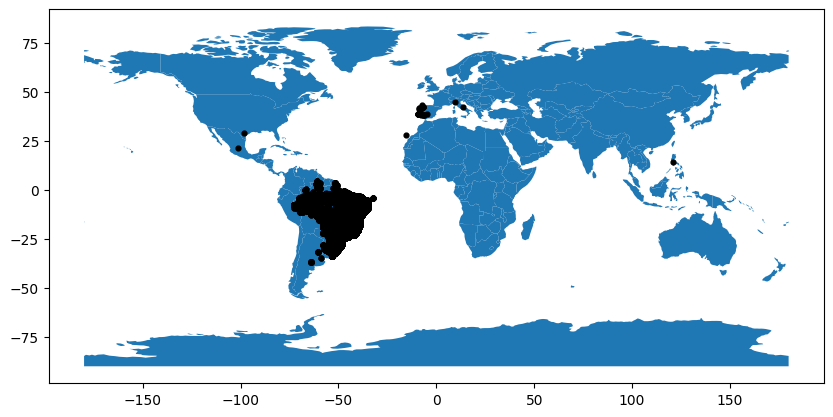

In [124]:

geometry = [Point(xy) for xy in zip(geo_cust['geolocation_lng'],
                                   geo_cust['geolocation_lat'])]
gdf = GeoDataFrame(geo_cust, geometry=geometry)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='black', markersize=12);

<ipython-input-125-42ccbe50c50d>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


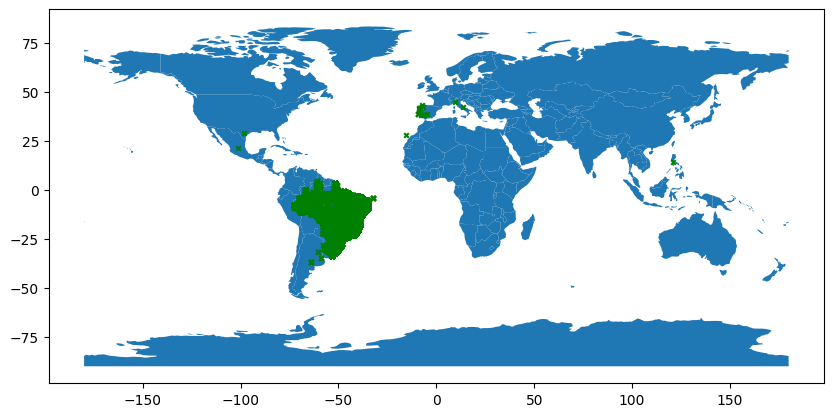

In [125]:
geometry = [Point(xy) for xy in zip(geo_sell['geolocation_lng'],
                                    geo_sell['geolocation_lat'])]
gdf3 = GeoDataFrame(geo_sell, geometry=geometry)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf3.plot(ax=world.plot(figsize=(10, 6)), marker='x', color='green', markersize=11);

In [126]:
#from google.colab import files
# Export the join into a CSV file in case you want to play around
#geo_cust_sell.to_csv("cust_sell_geo.csv",sep = ';')
#files.download('cust_sell_geo.csv')


In [127]:
geo_cust_sell.dtypes

zip_code_p           object
geolocation_lat     float64
geolocation_lng     float64
city                 object
state                object
customer_id          object
seller_id            object
_merge             category
dtype: object

##Percentage at each sub set of a join, Left is Geo, Rigth is Cust and Both is match
_merge                                                                                        
left_only                                            0.468486                                 
right_only                                           0.006956                                 
both                                                99.524558


Percentage at each sub set of a join, Left is Geo_Cust, Rigth is Seller and Both is match
_merge                                                                                               
left_only                                           44.775502                                        
right_only                                           0.003566                                        
both                                                55.220932                                        
makes sense to have only a few Zips for distribution centers

#Step 5 - Join Orders Review Product

Lets do some feature engineering before the join to calculate lags between different stages of the order

There are errors in the dates in the system. To fix lets simply not allow a date to be further than the previous one.
Can be adjusted to the average or a significant number later


In [128]:
orders_review_df

orders_rev_pro = pd.merge(orders_review_df,orders_product_df,on=['order_id'],how='outer',indicator=True)
print(orders_rev_pro['_merge'].value_counts())
print(orders_rev_pro['_merge'].count())


print (100*pd.DataFrame({'Percentage at each sub set of a join, Left is ord rev, Rigth is prod and Both is match': orders_rev_pro.groupby(['_merge']).size() / len(orders_rev_pro)}))


both          102425
left_only        775
right_only         0
Name: _merge, dtype: int64
103200
            Percentage at each sub set of a join, Left is ord rev, Rigth is prod and Both is match
_merge                                                                                            
left_only                                            0.750969                                     
right_only                                           0.000000                                     
both                                                99.249031                                     


In [129]:
orders_rev_pro.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
review_id                                object
review_score                             object
review_comment_title                     object
review_comment_message                   object
review_creation_date             datetime64[ns]
review_answer_timestamp          datetime64[ns]
review                                     bool
product_id                               object
Sum_order_item_id                       float64
seller_id                                object
shipping_limit_date                      object
Sum_price                               float64
Sum_freight_value                       

In [130]:
geo_cust.drop('_merge', inplace=True, axis=1, errors='ignore')
geo_cust.drop('geolocation_lat ', inplace=True, axis=1, errors='ignore')
geo_cust.drop('geolocation_lng', inplace=True, axis=1, errors='ignore')

geo_sell.drop('_merge', inplace=True, axis=1, errors='ignore')
geo_sell.drop('geolocation_lat ', inplace=True, axis=1, errors='ignore')
geo_sell.drop('geolocation_lng', inplace=True, axis=1, errors='ignore')


geo_sell.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459062 entries, 0 to 459061
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   zip_code_p       459062 non-null  object 
 1   geolocation_lat  458929 non-null  float64
 2   city             459062 non-null  object 
 3   state            459062 non-null  object 
 4   seller_id        149774 non-null  object 
dtypes: float64(1), object(4)
memory usage: 21.0+ MB


## CLEAN UP AND RENAMING OF SIMPLIFIED TABLES

In [131]:


orders_rev_pro.drop('order_approved_at', inplace=True, axis=1, errors='ignore')
orders_rev_pro.drop('order_delivered_carrier_date', inplace=True, axis=1, errors='ignore')
orders_rev_pro.drop('order_delivered_customer_date', inplace=True, axis=1, errors='ignore')
orders_rev_pro.drop('review_id', inplace=True, axis=1, errors='ignore')
orders_rev_pro.drop('review_answer_timestamp', inplace=True, axis=1, errors='ignore')
orders_rev_pro.drop('Right_product_id', inplace=True, axis=1, errors='ignore')
orders_rev_pro.drop('geolocation_lng', inplace=True, axis=1, errors='ignore')
orders_rev_pro.drop('shipping_limit_date', inplace=True, axis=1, errors='ignore')
orders_rev_pro.drop('review_creation_date', inplace=True, axis=1, errors='ignore')


orders_rev_pro.dtypes

orders_rev_pro= orders_rev_pro.rename(columns={'order_purchase_timestamp':'purchase_date',
                                               'order_estimated_delivery_date': 'delivery_date',
                                               'product_category_name_english': 'category_name',
                                               'product_description_lenght': 'des_lenght'})

In [132]:
orders_rev_pro.drop('_merge', inplace=True, axis=1, errors='ignore')

orders_cust_pro = pd.merge(orders_rev_pro,geo_cust,on=['customer_id'],how='outer',indicator=True)

print(orders_cust_pro['_merge'].value_counts())
print(orders_cust_pro['_merge'].count())


print (100*pd.DataFrame({'Percentage at each sub set of a join, Left is Master, Rigth is Geo and Both is match': orders_cust_pro.groupby(['_merge']).size() / len(orders_cust_pro)}))



both          4844376
right_only      21956
left_only        3587
Name: _merge, dtype: int64
4869919
            Percentage at each sub set of a join, Left is Master, Rigth is Geo and Both is match
_merge                                                                                          
left_only                                            0.073656                                   
right_only                                           0.450849                                   
both                                                99.475494                                   


In [133]:
orders_cust_pro= orders_cust_pro.rename(columns={'zip_code_p':'cust_zip',
                                               'city': 'cust_city',
                                               'state': 'cust_state'})
orders_cust_pro.dtypes

order_id                          object
customer_id                       object
order_status                      object
purchase_date             datetime64[ns]
delivery_date             datetime64[ns]
review_score                      object
review_comment_title              object
review_comment_message            object
review                            object
product_id                        object
Sum_order_item_id                float64
seller_id                         object
Sum_price                        float64
Sum_freight_value                float64
product_category_name             object
product_name_lenght              float64
des_lenght                       float64
product_photos_qty               float64
product_weight_g                 float64
product_length_cm                float64
product_height_cm                float64
product_width_cm                 float64
product_error                     object
category_name                     object
cust_zip        

#Step 6 - Analyze operational Issues Hypothesis

It was already observed that some dates are missing for delivered and carrier. The idea is to see if this had an impact on the ratings

###Correct dates in the chain to have better visibility on bottleneck operational

In [134]:
#Drop create features for seasonality

orders_cust_pro['day'] = orders_cust_pro['purchase_date'].dt.day
orders_cust_pro['month'] = orders_cust_pro['purchase_date'].dt.month
orders_cust_pro['year'] = orders_cust_pro['purchase_date'].dt.year


orders_cust_pro.dtypes

order_id                          object
customer_id                       object
order_status                      object
purchase_date             datetime64[ns]
delivery_date             datetime64[ns]
review_score                      object
review_comment_title              object
review_comment_message            object
review                            object
product_id                        object
Sum_order_item_id                float64
seller_id                         object
Sum_price                        float64
Sum_freight_value                float64
product_category_name             object
product_name_lenght              float64
des_lenght                       float64
product_photos_qty               float64
product_weight_g                 float64
product_length_cm                float64
product_height_cm                float64
product_width_cm                 float64
product_error                     object
category_name                     object
cust_zip        

In [135]:
# Export the join into a CSV file in case you want to play around

orders_rev_pro.replace(';', ',')
orders_rev_pro.to_csv("orders_rev_pro.csv",sep = ';')
#files.download('orders_rev_pro.csv')

#Step 7 - Linear Regression

After Analizying the Dataset, it is clear that dropping sales is the most concerning observation so let us explore what is happening

## Data transformations for Linear Regression

In [136]:
orders_cust_pro.dtypes

order_id                          object
customer_id                       object
order_status                      object
purchase_date             datetime64[ns]
delivery_date             datetime64[ns]
review_score                      object
review_comment_title              object
review_comment_message            object
review                            object
product_id                        object
Sum_order_item_id                float64
seller_id                         object
Sum_price                        float64
Sum_freight_value                float64
product_category_name             object
product_name_lenght              float64
des_lenght                       float64
product_photos_qty               float64
product_weight_g                 float64
product_length_cm                float64
product_height_cm                float64
product_width_cm                 float64
product_error                     object
category_name                     object
cust_zip        

In [137]:
orders_cust_pro.drop('_merge', inplace=True, axis=1, errors='ignore')
# We could also transform our data set to capture N of customers per day in the meantime
orders_cust_pro['Year-Month-Day-Hour'] = orders_cust_pro['purchase_date'].dt.strftime('%Y-%m-%d-%H')

#Product specs will come in handy when we want to link back to our catalogue but lets drop for now all categorical features


In [138]:
orders_cust_pro.dtypes

order_id                          object
customer_id                       object
order_status                      object
purchase_date             datetime64[ns]
delivery_date             datetime64[ns]
review_score                      object
review_comment_title              object
review_comment_message            object
review                            object
product_id                        object
Sum_order_item_id                float64
seller_id                         object
Sum_price                        float64
Sum_freight_value                float64
product_category_name             object
product_name_lenght              float64
des_lenght                       float64
product_photos_qty               float64
product_weight_g                 float64
product_length_cm                float64
product_height_cm                float64
product_width_cm                 float64
product_error                     object
category_name                     object
cust_zip        

In [139]:
#Doing it daily for illustrative purposed but can be expanded to other features, etc
order_yr_wk = orders_cust_pro.groupby(['Year-Month-Day-Hour'], as_index=False)\
.agg(price = ('Sum_price', 'mean'),
     freight = ('Sum_freight_value', 'mean'),
     pname = ('product_name_lenght','mean'),
     desc = ('des_lenght','mean'),
     item = ('Sum_order_item_id','mean'),
     photos = ('product_photos_qty','sum'),
     cat= ('category_name','nunique'),
     sell = ('seller_id','nunique'),
     cust = ('customer_id','count'),
     city = ('cust_city','nunique'),
     state = ('cust_state','nunique'),
     order = ('order_id','nunique'))

order_yr_wk['sell']= order_yr_wk['sell'].astype(float)
order_yr_wk['cust']=order_yr_wk['cust'].astype(float)
order_yr_wk['order']=order_yr_wk['order'].astype(float)

## Define Xs and Ys

In [140]:
#Create transformation Matrix

trx = order_yr_wk
#trx = trx.rename(columns={'day_x':'day','month_x': 'month','year_x': 'year'})
print('this is the lenght of our training data set as we reserve 1/3 for testing:')
l_x = round(2*len(trx)/3)
print( l_x)
trx = trx.dropna()

# Lets try to predict customer count as a function of product specs, n of sellers and revenue

y= trx['cust']

X = trx.drop(columns = ['cust','city','state', 'order','Year-Month-Day-Hour','sell'])

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

X.count()


this is the lenght of our training data set as we reserve 1/3 for testing:
8079


price      12049
freight    12049
pname      12049
desc       12049
item       12049
photos     12049
cat        12049
dtype: int64

### Splitting X and y into training and testing: Case 1

In [141]:
# For "apples-to-apples" comparisons, set a starting value ("seed") for the random number generator
np.random.seed(77300)
#print(y.head())
# split the data randomly into 80% train and 20% test samples
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30)
# IMPORTANT: these samples are stratified, i.e., the proportion of retained and not-retained customers is the same in both

# Lets check the results
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(8434, 7)
(3615, 7)
(8434,)
(3615,)


### Build linear Model

In [142]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train) # In this package, by default, the regression will have no intercept, hence we need to manually add it to the X matrix, and call the result X_sm

lm = sm.OLS(y_train, X_train_sm).fit() # Fit/"train"/"learn" a linear regression ("ordinary least squares", OLS) with vector Y as dependent and matrix X_sm as independent

lm.summary() # Display the summary of model results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cust   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     7796.
Date:                Thu, 30 Nov 2023   Prob (F-statistic):               0.00
Time:                        09:30:47   Log-Likelihood:                -53111.
No. Observations:                8434   AIC:                         1.062e+05
Df Residuals:                    8426   BIC:                         1.063e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.1703     12.187      3.132      0.002      14.281      62.059
price          0.0018      0.013      0.137      0.891      -0.024       0.028
freight       -0.3995      0.164     -2.438      0.015      -0.721      -0.078
pname         -0.9705      0.233     -4.168      0.000      -1.427      -0.514
desc          -0.0213      0.004     -5.857      0.000      -0.028      -0.014
item           9.6229      1.794      5.364      0.000       6.106      13.140
photos         0.2626      0.002    106.183      0.000       0.258       0.267
cat           31.3246      0.555     56.485      0.000      30.237      32.412
==============================================================================
Omnibus:                     2383.345   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32753.320
Skew:                           0.970   Prob(JB):                         0.00
Kurtosis:                      12.457   Cond. No.                     1.20e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [143]:
X_test['test'] = 1
#X_test.shape

### Cross Validation for the Linear Regression

In [144]:
# Use the trained model to predict the cust for the testing data. Call the vector of predicted prices Y_pred

y_pred = lm.predict(X_test)

print(type(y_pred))
print(type(y_test))
# Finally, calculate the metric for the model quality. As we discussed in class, there are many possible metrics, one of them is MAPE (mean absolute percentage error) https://en.wikipedia.org/wiki/Mean_absolute_percentage_error

percent_errors = np.abs((y_test - y_pred) / y_test) *100

percent_errors[0:4] # Display first 4 percentage errors (8151-8042)/8151 = 1.33%, (7426-6704)/6704 = 10.77%, etc.



<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


3064    2680.518023
9932    6669.352694
7226    3531.664850
1570    1414.391811
dtype: float64

In [145]:
y_pred.round(1)

3064    11122.1
9932    10763.3
7226    28944.4
1570     5785.0
4588     8793.3
         ...   
4931     5815.3
45       3574.2
9878    42083.6
9013    15098.0
9948     1759.0
Length: 3615, dtype: float64

In [146]:
y_test

3064    400.0
9932    159.0
7226    797.0
1570    382.0
4588    462.0
        ...  
4931     59.0
45       89.0
9878    771.0
9013    372.0
9948      8.0
Name: cust, Length: 3615, dtype: float64

Linear Model MAPE =  8327.897823670794 %


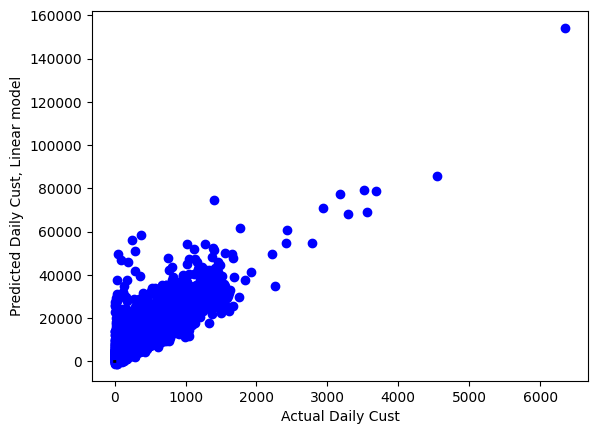

In [147]:
# Display MAPE

print("Linear Model MAPE = ", np.mean(percent_errors), "%")


plt.scatter(y_test, y_pred, color='blue') # actual vs predicted prices for the linear model
plt.ylabel('Predicted Daily Cust, Linear model') # vertical axis title
plt.xlabel('Actual Daily Cust') # horizontal axis title
plt.plot([0, 4], [0, 4], color='black', lw=2) # 45-degree line (at which error = 0)

#Step 8 - Classification Model Set-up

In [148]:
# First we define a set of functions to compute the metrics of the model

# ROC curve
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1, drop_intermediate = False)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.001, 1.001])
    plt.ylim([-0.001, 1.001])
    plt.xlabel('1-Specificity (False Negative Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

# Confusion Matrix returns in the format: cm[0,0], cm[0,1], cm[1,0], cm[1,1]: tn, fp, fn, tp

# Sensitivity
def custom_sensitivity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fn))

# Specificity
def custom_specificity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fp))

# Positive Predictive Value
def custom_ppv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fp))

# Negative Predictive Value
def custom_npv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fn))

# Accuracy
def custom_accuracy_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return ((tn+tp)/(tn+tp+fn+fp))

# Step 9 Decision Tree Example: CART

In [149]:
orders_cust_pro.dtypes

order_id                          object
customer_id                       object
order_status                      object
purchase_date             datetime64[ns]
delivery_date             datetime64[ns]
review_score                      object
review_comment_title              object
review_comment_message            object
review                            object
product_id                        object
Sum_order_item_id                float64
seller_id                         object
Sum_price                        float64
Sum_freight_value                float64
product_category_name             object
product_name_lenght              float64
des_lenght                       float64
product_photos_qty               float64
product_weight_g                 float64
product_length_cm                float64
product_height_cm                float64
product_width_cm                 float64
product_error                     object
category_name                     object
cust_zip        

In [150]:
# "Cleaning" the data -- part 1: converting data types that should be categorican into "category"
trx= orders_cust_pro[['Year-Month-Day-Hour','category_name','des_lenght',
                      'product_photos_qty','Sum_order_item_id','product_weight_g',
                      'product_width_cm','product_length_cm','product_height_cm',
                      'product_name_lenght',
                      'Sum_price','Sum_freight_value']]

trx = orders_cust_pro.groupby(['category_name'], as_index=False)\
.agg(price = ('Sum_price', 'mean'),
     pname = ('product_name_lenght','mean'),
     desc = ('des_lenght','mean'),
     item = ('Sum_order_item_id','mean'),
     photos = ('product_photos_qty','sum'),
     weight = ('product_weight_g','mean'),
     width= ('product_width_cm','mean'),
     leng = ('product_length_cm','mean'))


trx.dtypes
trx = trx.dropna()


In [151]:
trx.dtypes

category_name     object
price            float64
pname            float64
desc             float64
item             float64
photos           float64
weight           float64
width            float64
leng             float64
dtype: object

In [152]:

y_c = trx['category_name']
X_c= trx

X_c = X_c.drop(columns = ['category_name'
                          ], errors= 'ignore')

X_c.dtypes

price     float64
pname     float64
desc      float64
item      float64
photos    float64
weight    float64
width     float64
leng      float64
dtype: object

###Define Categorical Xs and Ys

In [77]:
# For "apples-to-apples" comparisons, set a starting value ("seed") for the random number generator
np.random.seed(77300)

# split the data randomly into 80% train and 20% test samples
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c,y_c, test_size = 0.20)
# IMPORTANT: these samples are stratified, i.e., the proportion of retained and not-retained customers is the same in both

# Lets check the results
print(X_train_c.shape)
print(X_test_c.shape)
print(y_train_c.shape)
print(y_test_c.shape)
print(y_test_c[0:5])
print(y_pred_c[0:5])

(56, 8)
(15, 8)
(56,)
(15,)
14                    computers
32                fashion_sport
42                 garden_tools
29    fashion_childrens_clothes
6                          baby
Name: category_name, dtype: object


NameError: ignored

In [ ]:
# Define a CART model and call it classifier_DT
classifier_DT = DecisionTreeClassifier(max_leaf_nodes = 5, random_state=77300) # random_state -- is same as random seed, neede to get the same result every time we rerun

# Select the threshold value -- we will use Т=0.2873. Why? Why not 50%?
#Because 28.73% -- is the average probability of default in our data
class_threshold = 0.5

# Train the model classifier_DT on the training data
classifier_DT.fit(X_train_c, y_train_c)

#  Use the trained model to predict testing data
y_pred_prob_c = classifier_DT.predict_proba(X_test_c)[:,1] # probabilities
y_pred_c = np.where(y_pred_prob_c > class_threshold, 1, 0) # classification

print(y_pred_prob_c[0:5]) # first 5 probabilities
print('')
print(y_pred_c[0:5]) # resultant predicted classification
print('')
print(y_test_c[0:5]) # actual outcomes

# WOW -- the CART model made no mistakes on the first 5 categories!

In [ ]:
# Visualizing the resultant tree

from sklearn import tree

plt.figure(figsize=(20,20))
tree.plot_tree(classifier_DT.fit(X_train_c, y_train_c), feature_names = X_train_c.columns, filled = True,
                rounded = True)
print('CART tree with 5 leafs')

#Next steps





*   Discuss with Business validity of modeling
*   Build data pipeilines
*   Data Quality Dashboard
*   Enrich Product Category
*   Customer Clustering and Segmentation
*   Review score classification model
*   Freight Linear Regression
*   NLP for translations
*   Geo Outliers Correction - External source for geo data
*   Tableau and overall ux finetuning
*   Payment Modeling




